# Time Series Forcasting of the Big Mac Dataset

## Objective
The main purpose of this analysis is to develop a model that forecasts the Big Mac prices in the near future using the past prices from 2000 to 2021. To do so, we will split the data into a training set from 2000 to 2019 and forecast the prices from 2020 to the end of 2021. We will be working on the Smoothing and ARIMA techniques to train and fir the model.

## Dataset
The dataset has prices over time for the popular McDonald’s sandwich. The idea is that it serves as an interesting economic indicator because you can get it around the world. This dataset was created by [The Economist](https://github.com/TheEconomist/big-mac-data) and contains more than 7000 Big Mac prices along with Country & Date and other features.

From this dataset, we will work only on the big mac prices in the USA in Dollars. And, we will explore different ways of optimizing the R2 score on the test (hold out) set.

## EDA

In [1]:
# imports
import pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, numpy as np, seaborn as sns, os
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 6)

In [2]:
# changing the path to the data folder
os.chdir('data/The Big Mac Economic Index')

In [3]:
# reading the data from a csv file without any processing
data = pd.read_csv('big-mac-full-index.csv')
data.head()

,date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_dollar,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
0,2000-04-01,ARG,ARS,Argentina,2.50,1.00,2.500000,-0.00398,0.05007,-0.16722,-0.09864,1.09091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-04-01,AUS,AUD,Australia,2.59,1.68,1.541667,-0.38579,-0.35246,-0.48645,-0.44416,0.28939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-04-01,BRA,BRL,Brazil,2.95,1.79,1.648045,-0.34341,-0.30778,-0.45102,-0.40581,0.37836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,CAN,CAD,Canada,2.85,1.47,1.938776,-0.22758,-0.18566,-0.35417,-0.30099,0.62152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-04-01,CHE,CHF,Switzerland,5.90,1.70,3.470588,0.38270,0.45774,0.15609,0.25130,1.90267,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1520 non-null   object 
 1   iso_a3         1520 non-null   object 
 2   currency_code  1520 non-null   object 
 3   name           1520 non-null   object 
 4   local_price    1520 non-null   float64
 5   dollar_ex      1520 non-null   float64
 6   dollar_price   1520 non-null   float64
 7   USD_raw        1520 non-null   float64
 8   EUR_raw        1520 non-null   float64
 9   GBP_raw        1520 non-null   float64
 10  JPY_raw        1520 non-null   float64
 11  CNY_raw        1520 non-null   float64
 12  GDP_dollar     812 non-null    float64
 13  adj_price      812 non-null    float64
 14  USD_adjusted   812 non-null    float64
 15  EUR_adjusted   812 non-null    float64
 16  GBP_adjusted   812 non-null    float64
 17  JPY_adjusted   812 non-null    float64
 18  CNY_adju

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
local_price,1520.0,29246.122122,792628.452651,1.050000,7.622500,26.905000,130.000000,3.016410e+07
dollar_ex,1520.0,5954.089260,113824.123061,0.300800,3.067250,7.756250,51.079375,3.613989e+06
dollar_price,1520.0,3.302952,1.294416,0.639966,2.355730,3.090745,4.028824,9.081066e+00
USD_raw,1520.0,-0.235312,0.300546,-0.865250,-0.450877,-0.299105,-0.079790,1.273070e+00
EUR_raw,1520.0,-0.233442,0.276641,-0.834710,-0.437865,-0.277075,-0.071912,8.706300e-01
GBP_raw,1520.0,-0.179180,0.303520,-0.851510,-0.400230,-0.230475,0.000000,1.137640e+00
JPY_raw,1520.0,0.040262,0.392323,-0.786980,-0.253005,-0.003535,0.231897,2.159800e+00
CNY_raw,1520.0,0.461894,0.631899,-0.755270,0.032647,0.302655,0.788355,4.386230e+00
GDP_dollar,812.0,25536.976782,22651.269196,1049.749000,7182.227750,14812.563500,41611.455250,1.005790e+05
adj_price,812.0,3.720229,0.961036,2.327804,2.977383,3.341639,4.424376,7.434129e+00


In [6]:
# subsetting the dataset and working only on the USA dollar prices
macUS = data[data['name'] == 'United States'][['date', 'dollar_price']]
macUS.head()

,date,dollar_price
26,2000-04-01,2.51
54,2001-04-01,2.54
86,2002-04-01,2.49
118,2003-04-01,2.71
158,2004-05-01,2.90


In [7]:
macUS.dtypes

date             object
dollar_price    float64
dtype: object

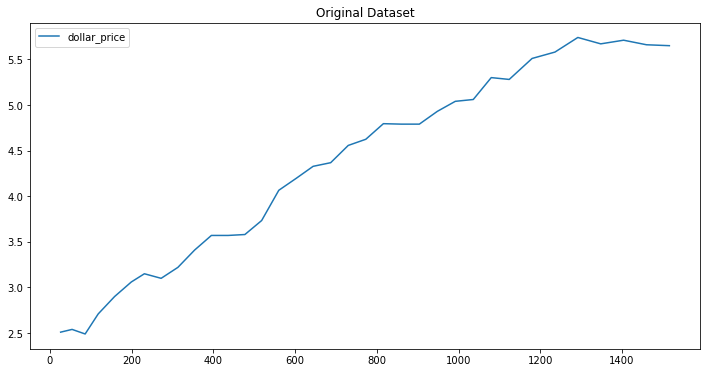

In [8]:
macUS.plot()
plt.title('Original Dataset');
plt.savefig('Original Dataset.png')

The date is read as a string, so we will make it a datetime object with a standard fgrequency

In [9]:
date = np.array(macUS['date'], dtype = 'datetime64[M]')
date

array(['2000-04', '2001-04', '2002-04', '2003-04', '2004-05', '2005-06',
       '2006-01', '2006-05', '2007-01', '2007-06', '2008-06', '2009-07',
       '2010-01', '2010-07', '2011-07', '2012-01', '2012-07', '2013-01',
       '2013-07', '2014-01', '2014-07', '2015-01', '2015-07', '2016-01',
       '2016-07', '2017-01', '2017-07', '2018-01', '2018-07', '2019-01',
       '2019-07', '2020-01', '2020-07', '2021-01', '2021-07'],
      dtype='datetime64[M]')

In [10]:
macUS.set_index(date, inplace = True)
macUS.pop('date')
macUS.head()

,dollar_price
2000-04-01,2.51
2001-04-01,2.54
2002-04-01,2.49
2003-04-01,2.71
2004-05-01,2.90


In [11]:
new_index = pd.date_range(date.min(), date.max(), freq = 'MS')
new_index

DatetimeIndex(['2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01',
               '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01',
               '2000-12-01', '2001-01-01',
               ...
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01'],
              dtype='datetime64[ns]', length=256, freq='MS')

Now, we reindex the data with the new datetime index and interpolate to fill the NaN values

In [12]:
macUSnew = macUS.reindex(new_index)
macUSnew.interpolate(method = 'time', inplace = True)
macUSnew.head()

,dollar_price
2000-04-01,2.510000
2000-05-01,2.512466
2000-06-01,2.515014
2000-07-01,2.517479
2000-08-01,2.520027


The dataset has grown larger due to frequency effect

In [13]:
macUS.shape, macUSnew.shape

((35, 1), (256, 1))

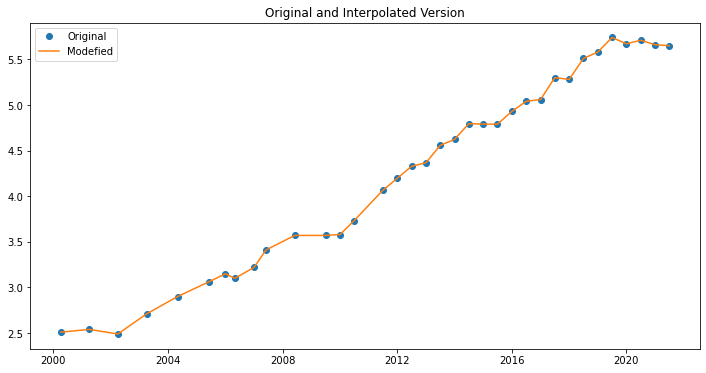

In [14]:
plt.plot(macUS, label = 'Original', ls = '', marker = 'o')
plt.plot(macUSnew, label = 'Modefied')
plt.legend()
plt.title('Original and Interpolated Version')
plt.savefig('Original and Interpolated Version.png')

In [15]:
# stationarity
print(f'P-value = {adfuller(macUSnew)[1]}')

P-value = 0.834774448084183


Since the dataset is nonstationary we will transform it and shift it to get a stationary series

P-value = 2.7640213557464595e-24


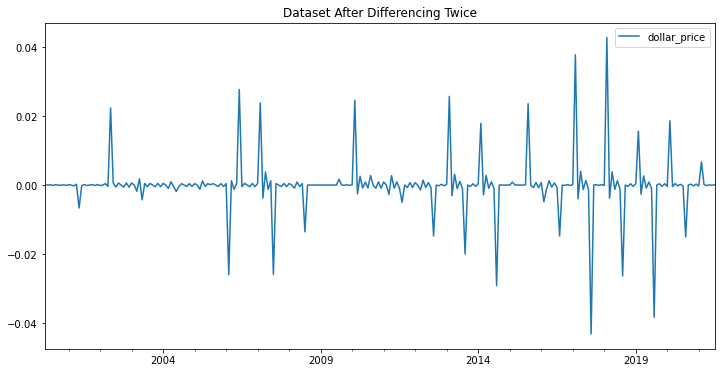

In [16]:
macUSshifted = macUSnew.diff().diff().fillna(0)
print(f'P-value = {adfuller(macUSshifted)[1]}')
macUSshifted.plot()
plt.title('Dataset After Differencing Twice')
plt.savefig('Dataset After Differencing Twice.png')

In [17]:
macUSshifted = macUSshifted + 0.5

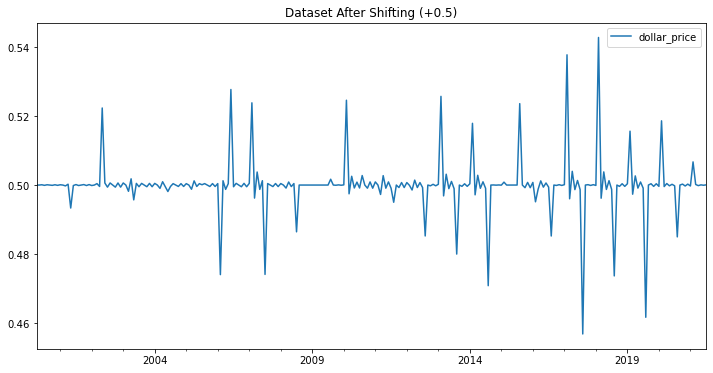

In [18]:
macUSshifted.plot()
plt.title('Dataset After Shifting (+0.5)')
plt.savefig('Dataset After Shifting (+0.5).png')

## Training Models and Optimization

### Section 01: Smoothing Models

In [19]:
# forecasting only the last 16 months
train, test = macUSshifted[:240], macUSshifted[240:]
train.shape, test.shape

((240, 1), (16, 1))

In [20]:
test.head()

,dollar_price
2020-04-01,0.500440
2020-05-01,0.499780
2020-06-01,0.500220
2020-07-01,0.499780
2020-08-01,0.484983


In [21]:
test.tail()

,dollar_price
2021-03-01,0.500166
2021-04-01,0.499834
2021-05-01,0.500055
2021-06-01,0.499945
2021-07-01,0.500055


In [22]:
# a simple function to plot the results
def test_model(train, test, forecasted):
    print(f'R2 score = {r2_score(test, forecasted)}')
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(forecasted, label = 'Forecasted')
    plt.legend()

In [23]:
model00 = ExponentialSmoothing(train, seasonal = 'add', seasonal_periods = 36).fit(optimized = True)
forecasted = model00.forecast(len(test))

C:\Users\ehhho\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\ehhho\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


R2 score = 0.762758070849776


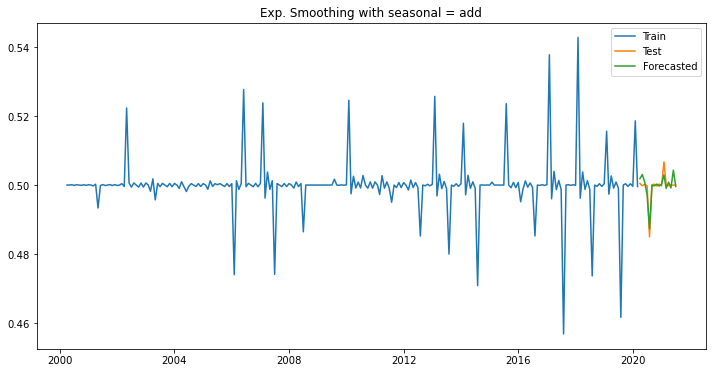

In [24]:
test_model(train, test, forecasted)
plt.title('Exp. Smoothing with seasonal = add')
plt.savefig('Exp. Smoothing with seasonal = add.png')

In [25]:
model01 = ExponentialSmoothing(train, seasonal = 'mul', seasonal_periods = 36).fit(optimized = True)
forecasted = model01.forecast(len(test))

C:\Users\ehhho\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\ehhho\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


R2 score = 0.7632582828180441


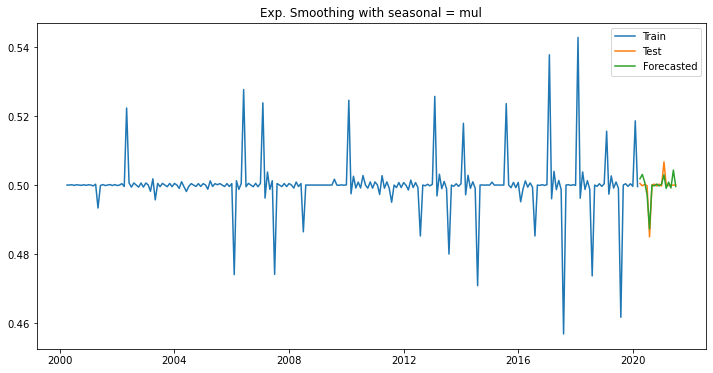

In [26]:
test_model(train, test, forecasted)
plt.title('Exp. Smoothing with seasonal = mul')
plt.savefig('Exp. Smoothing with seasonal = mul.png')

---



in this part, we worked on many different smoothing settings of the exponential smoothing module. We run through additive trend and no seasonality as found from the dataset but that didn’t give us good results. So, we made random combinations of the trend and seasonality along with seasonality periods to account for the covid-19 period and the economic depression from 2008 to 2010. We also had a flatten out period from 2000 to 2004 due to 11th Sep. disaster. The point is that these periods are not separated with a constant separation period so we can’t set the best seasonal period for the model. So, we choose the one that gave us the highest R2 score which is 36 months. The following two graphs show the forecasting of a no trend and additive and multiplicative seasonality. R2 score, respectively, is 0.762758070849776 and 0.7632582828180441.

### Section 02: ARMA/ ARIMA Models

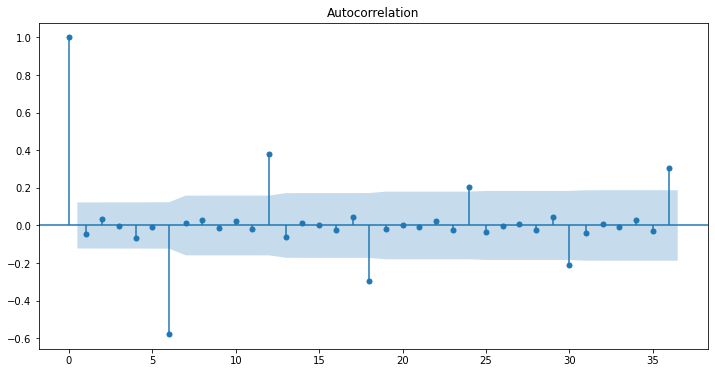

In [27]:
plot_acf(macUSshifted, lags = 36)
plt.savefig('Autocorrelation.png')

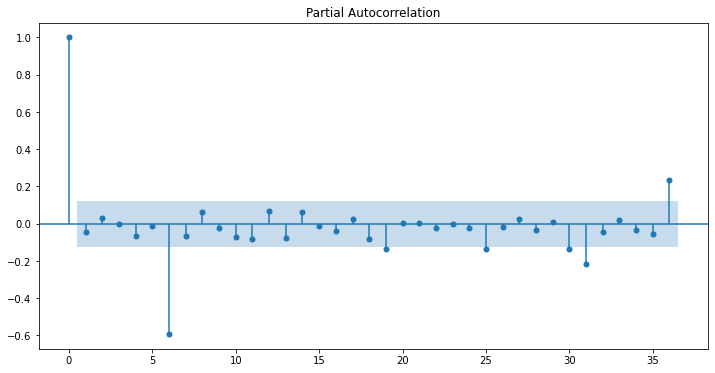

In [28]:
plot_pacf(macUSshifted, lags = 36)
plt.savefig('Partial Autocorrelation.png')

In [29]:
model02 = ARIMA(train, order = (0, 0, 0), seasonal_order = (1, 0, 1, 36)).fit()
predicted = model02.predict(start = '2020-04-01', end = '2021-07-01')

C:\Users\ehhho\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


R2 score = 0.8298052117442202


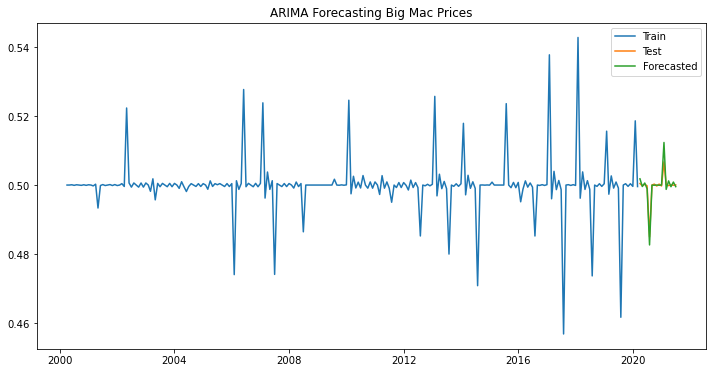

In [30]:
test_model(train, test, predicted)
plt.title('ARIMA Forecasting Big Mac Prices');
plt.savefig('ARIMA Forecasting Big Mac Prices.png')

To make sure that we have chosen the correct model, we will run an auto_arima test to search for the best (p, d, q)(P, D, Q, S)

In [31]:
model03 = auto_arima(train, start_p = 0, max_p = 3, start_P = 0, max_P = 3, m = 36,
                     seasonal = True, step_wise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,1)[36] intercept   : AIC=-1641.364, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[36] intercept   : AIC=-1631.628, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[36] intercept   : AIC=inf, Time=7.30 sec
 ARIMA(0,0,1)(0,0,1)[36] intercept   : AIC=-1643.236, Time=4.40 sec
 ARIMA(0,0,0)(0,0,0)[36]             : AIC=350.457, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[36] intercept   : AIC=-1630.068, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[36] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(0,0,1)(0,0,2)[36] intercept   : AIC=-1658.453, Time=19.35 sec
 ARIMA(0,0,1)(1,0,2)[36] intercept   : AIC=-1654.553, Time=40.29 sec
 ARIMA(0,0,0)(0,0,2)[36] intercept   : AIC=-1660.042, Time=15.58 sec
 ARIMA(0,0,0)(0,0,1)[36] intercept   : AIC=-1644.937, Time=1.80 sec
 ARIMA(0,0,0)(1,0,2)[36] intercept   : AIC=-1656.028, Time=53.33 sec
 ARIMA(0,0,0)(1,0,1)[36] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(1,0,0)(0,0,2)[36] intercept   : AIC=-1658.222, Time=21.14 sec
 ARIMA(1,0,1)(0,0,2)

---

The dataset is stationary, so we don’t need to use the integrated facility on the ARIMA model. We then, run an auto_arima function on the training dataset to find the best fit. The output came to be ARIMA(0,0,0)(0,0,2)[36]. But, to avoid the non-inverting seasonal initialization, to maximize the R2 score, and follow the results recommended from the ACF and PACF plot (coming soon) we set the parameters as follows ARIMA(0,0,0)(1,0,1)[36]. The R2 score came to be 0.8298052117442202 

## Deep Learning Forecasting using RNN

### Section 01: Traing The Stationary Data using Simple RNN

In [32]:
# imports
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator as tg

In [33]:
train, test = macUSshifted[:240], macUSshifted[240:]
train.shape, test.shape

((240, 1), (16, 1))

In [34]:
# scaling the dataset using a standard scaler to be fed in the Neural Network
scaler = StandardScaler().fit(train)
scaled_train, scaled_test = scaler.transform(train), scaler.transform(test)

The class `TimeseriesGenerator` helps creasting training sets in a sequential mannar form the dataset. More about it in the follwing link [TimeseriesGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator)

In [35]:
length = 36
gen = tg(scaled_train, scaled_train, length = length, batch_size = 1)
X_init = scaled_train[-length:]

In [36]:
def makePredictions(model, X_init, steps = 16):
    X_init = X_init.reshape(1, -1, 1)
    predictions = []
    for _ in range(steps):
        pred = model.predict(X_init)[0][0]
        predictions.append(pred)
        X_init[:, :-1, :] = X_init[:, 1:, :]
        X_init[:, -1, :] = pred
    return np.array(predictions)

In [37]:
model04 = Sequential()  
model04.add(SimpleRNN(36, input_shape = (length, 1)))
model04.add(Dense(1))
model04.compile(loss = 'mean_squared_error', optimizer= 'adam')
model04.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 36)                1368      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


In [38]:
model04.fit(gen, epochs = 20, verbose = 0)

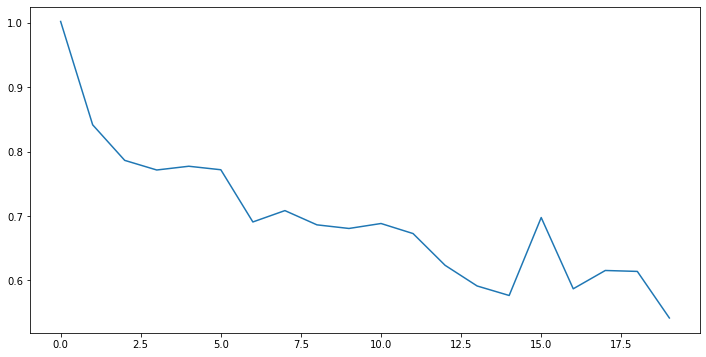

In [39]:
# plotting the loss function per epoch
plt.plot(model04.history.history['loss'])

In [40]:
predictions = makePredictions(model04, X_init)
predictions = pd.DataFrame(scaler.inverse_transform(predictions), index = test.index, columns = ['dollar_price'])

R2 score = 0.43534902323976155


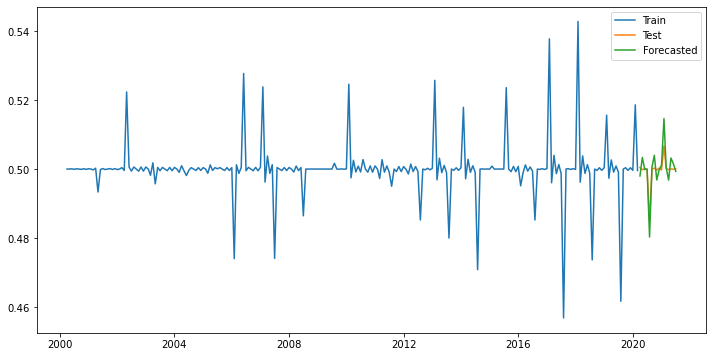

In [41]:
test_model(train, test, predictions)

---

### Section 02: Traing The Stationary Data using LSTM

In [42]:
model05 = Sequential()
model05.add(LSTM(100, input_shape = (length, 1)))
model05.add(Dense(1))
model05.compile(loss = 'mean_squared_error', optimizer= 'adam')
model05.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
model05.fit(gen, epochs = 20, verbose = 0)

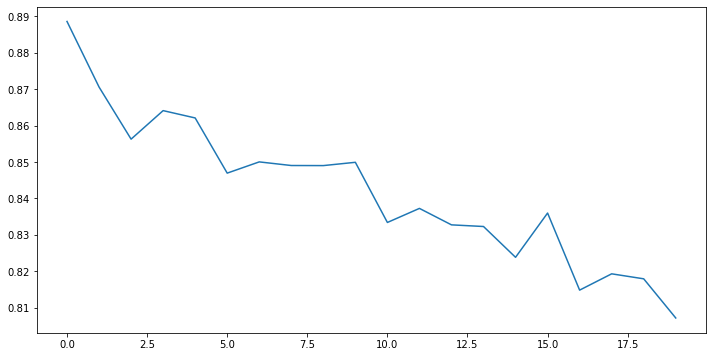

In [44]:
plt.plot(model05.history.history['loss'])

In [45]:
predictions = makePredictions(model05, X_init)
predictions = pd.DataFrame(scaler.inverse_transform(predictions), index = test.index, columns = ['dollar_price'])

R2 score = -0.0675863841878015


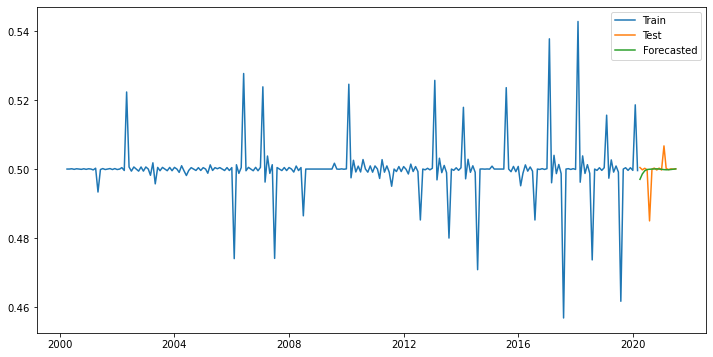

In [46]:
test_model(train, test, predictions)

---

### Section 03: Traing The Nonstationary Data using Simple RNN

In [47]:
train, test = macUSnew[:240], macUSnew[240:]
train.shape, test.shape

((240, 1), (16, 1))

In [48]:
scaler = StandardScaler().fit(train)
scaled_train, scaled_test = scaler.transform(train), scaler.transform(test)

In [49]:
length = 36
gen = tg(scaled_train, scaled_train, length = length, batch_size = 1)
X_init = scaled_train[-length:]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 36)                1368      
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________
None
R2 score = -5.551938724096919


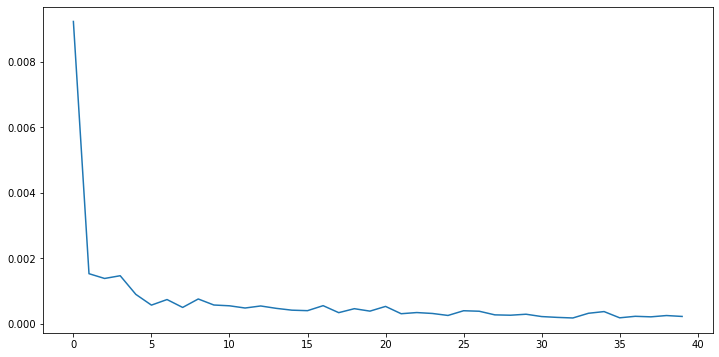

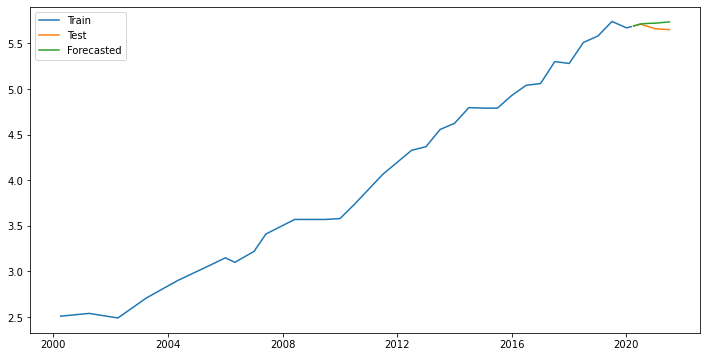

In [50]:
model06 = Sequential()  
model06.add(SimpleRNN(36, input_shape = (length, 1)))
model06.add(Dense(1))
model06.compile(loss = 'mean_squared_error', optimizer= 'adam')
print(model06.summary())
model06.fit(gen, epochs = 40, verbose = 0)
plt.figure()
plt.plot(model06.history.history['loss'])
predictions = makePredictions(model06, X_init)
predictions = pd.DataFrame(scaler.inverse_transform(predictions), index = test.index, columns = ['dollar_price'])
plt.figure()
test_model(train, test, predictions)

---

### Section 04: Traing The Nonstationary Data using LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
R2 score = -122.63808172107159


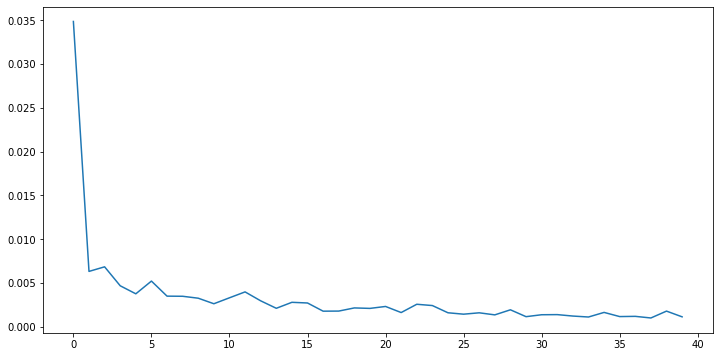

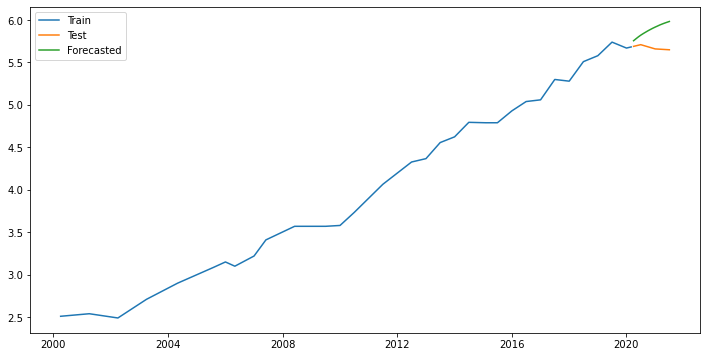

In [51]:
model07 = Sequential()
model07.add(LSTM(100, input_shape = (length, 1)))
model07.add(Dense(1))
model07.compile(loss = 'mean_squared_error', optimizer= 'adam')
print(model07.summary())
model07.fit(gen, epochs = 40, verbose = 0)
plt.figure()
plt.plot(model07.history.history['loss'])
predictions = makePredictions(model07, X_init)
predictions = pd.DataFrame(scaler.inverse_transform(predictions), index = test.index, columns = ['dollar_price'])
plt.figure()
test_model(train, test, predictions)

---

# Summary

1. The dataset is so hard to work with. The original dataset contains only 35 observations which are very little to work on. The hack of interpolating the data to standardize the index transforms it to 256 observations. This step accounts for the results we have here.

2. The mean-only model doesn’t give us satisfying results, so we didn’t mention it.

3. The Deep Learning approach is not working well because of the dataset size. it is very small for a Neural Network.

4. We also need more understanding of the time series forecasting to account for non-periodic seasonal effects of different events like covid-19.

---

# End of Project
--------------------------
Hossam Gamal Mostafa